# Import modules

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
import keras
from keras.applications import DenseNet121
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define functions

In [ ]:
def img2arr(filepath):
    im = cv2.imread(filepath)
    im = cv2.resize(im, (224, 224), interpolation = cv2.INTER_LANCZOS4)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype('float32')
    im /= 255
    
    return im

In [ ]:
def green_arr(im):
    green_channel = im[:,:,1]
    im = np.zeros(im.shape)
    im[:,:,1] = green_channel
    
    return im

In [ ]:
def high_contrast(image_arr):
    r_image, g_image, b_image = cv2.split(image_arr)
    
    r_image_eq = cv2.equalizeHist(r_image)
    g_image_eq = cv2.equalizeHist(g_image)
    b_image_eq = cv2.equalizeHist(b_image)

    image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
    cmap_val = None
    
    return image_eq

In [ ]:
def arr_convert(num):
    if num == 0:
        arr = [1, 0, 0, 0, 0]
    elif num == 1:
        arr = [0, 1, 0, 0, 0]
    elif num == 2:
        arr = [0, 0, 1, 0, 0]
    elif num == 3:
        arr = [0, 0, 0, 1, 0]
    elif num == 4:
        arr = [0, 0, 0, 0, 1]
        
    return arr

In [ ]:
def result_convert(pred):
  if int(pred)==0 :
    result= "0-No DR"
  elif int(pred)==1:
    result= "1-Mild"
  elif int(pred)==2:
    result= "2-Moderate"
  elif int(pred)==3:
    result= "3-Severe"
  elif int(pred)==4:
    result= "4-Proliferative DR"
  return result


In [ ]:
def image_import(file_names, rgb=True, green=False, high_contrast=False):
    x_train = []
    directory = '/content/train_images/'

    for file in file_names:
        arr = img2arr(directory + file + '.png')
        
        if rgb:
            pass
        elif green:
            arr = green_arr(arr)
        elif high_contrast:
            arr = high_contrast(arr)
        
        x_train.append(arr)
   
    x_train = np.array(x_train)
    
    return x_train

In [ ]:
def plot_data(history, ax = None, xlabel = 'Epoch #'):
    figure(figsize=(36, 24), dpi=80)
    
    dark_orange = '#f58231'
    light_orange = '#ffd8b1'
    dark_blue = '#000075'
    light_blue = '#ADD8E6'
    
    
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation Accuracy', color = dark_orange, ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training Accuracy', color = light_orange, ax = ax)
    sns.lineplot(x = 'epoch', y = 'val_loss', data = history, label = 'Validation Loss', color = dark_blue, ax = ax)
    sns.lineplot(x = 'epoch', y = 'loss', data = history, label = 'Training Loss', color = light_blue, ax = ax)
    
    ax.axhline(0.2, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 7)    
    ax.set_ylim([0.1, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()

In [ ]:
def compile_model(input_shape, DenseNet=False, ResNet=True):
    if DenseNet:
        model_type = DenseNet121(weights='/content/drive/MyDrive/cv/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=input_shape)
    elif ResNet:
        model_type = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        
    model = Sequential()
    model.add(model_type)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    datagen = ImageDataGenerator(
        zoom_range=0.2,
        fill_mode='constant',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=True)

    model.summary()
    
    return model

In [ ]:
def demo(id_demo):
  new_model = tf.keras.models.load_model('/content/drive/MyDrive/DoAnCuoiKy/model.h5')
  xtest=[]
  xtest.append(id_demo)
  test = image_import(xtest, rgb=True , green=False , high_contrast=False )
  Ypred = new_model.predict(test)
  int_Ypred = Ypred.astype(int)
  pred= np.argmax(Ypred, axis = 1)
  result=result_convert(pred)
  print("predicted results: ",result)
  return demo

# Download dataset from Kaggle

In [ ]:
from google.colab import files
!pip install -q kaggle

In [ ]:
uploaded= files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

In [ ]:
!unzip aptos2019-blindness-detection

# Import diagnosis data and file names

In [ ]:
y_train = pd.read_csv('/content/train.csv')

diagnosis = y_train['diagnosis']
id = y_train['id_code']

y_train = []
file_names = []

for i in diagnosis:
    y_train.append(i)
    
for i in id:
    file_names.append(i)
    
y_train = np.array(y_train)

y_list = []

for i in y_train:
    y_list.append(arr_convert(i))
    
y_train = np.array(y_list)

In [ ]:
type(file_names)

In [ ]:
y_train

# Import fundus images

In [ ]:
x_train = image_import(file_names, rgb=True , green=False , high_contrast=False )

In [ ]:
x_train

array([[[[0.01176471, 0.00392157, 0.00784314],
         [0.01176471, 0.00392157, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.00784314, 0.        , 0.00392157],
         [0.01176471, 0.00392157, 0.00784314]],

        [[0.01176471, 0.00392157, 0.00784314],
         [0.01176471, 0.00392157, 0.00784314],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.        , 0.00392157],
         [0.00784314, 0.        , 0.00392157]],

        [[0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.        , 0.00392157],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00784314, 0.00784314, 0.00784314]],

        ...,

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]

In [ ]:
type(file_names[0])

str

# Set aside 20% of data for testing

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)

# Compile model

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_shape = (224, 224, 3)

model = compile_model(input_shape, DenseNet=False , ResNet=True )

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Fit model to data and plot stats

In [ ]:
 datagen = ImageDataGenerator(
        zoom_range=0.2,
        fill_mode='constant',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=True)
 datagen.fit(x_train)

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), validation_data=(x_test, y_test), steps_per_epoch=(len(x_train)/32), epochs=15)

Epoch 1/15
80/80 [==============================] - 55s 479ms/step - loss: 0.3093 - accuracy: 0.6859 - val_loss: 6.0204 - val_accuracy: 0.5077
Epoch 2/15
80/80 [==============================] - 38s 477ms/step - loss: 0.2191 - accuracy: 0.7663 - val_loss: 2.6479 - val_accuracy: 0.5077
Epoch 3/15
80/80 [==============================] - 36s 449ms/step - loss: 0.1881 - accuracy: 0.7979 - val_loss: 4.5227 - val_accuracy: 0.5077
Epoch 4/15
80/80 [==============================] - 36s 447ms/step - loss: 0.1795 - accuracy: 0.8236 - val_loss: 1.5164 - val_accuracy: 0.5077
Epoch 5/15
80/80 [==============================] - 37s 464ms/step - loss: 0.1611 - accuracy: 0.8311 - val_loss: 4.4754 - val_accuracy: 0.5077
Epoch 6/15
80/80 [==============================] - 38s 467ms/step - loss: 0.1497 - accuracy: 0.8494 - val_loss: 2.8211 - val_accuracy: 0.5077
Epoch 7/15
80/80 [==============================] - 37s 455ms/step - loss: 0.1472 - accuracy: 0.8482 - val_loss: 4.0996 - val_accuracy: 0.5077

<Figure size 2880x1920 with 0 Axes>

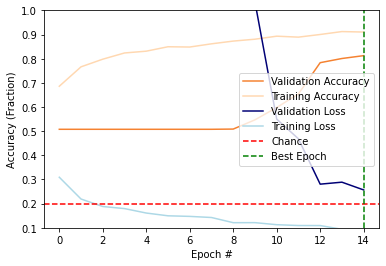

In [ ]:
plot_data(history)

In [ ]:
y_train.shape

(2563, 5)

# Save model to file

In [ ]:
model.save('/content/drive/MyDrive/DoAnCuoiKy/model.h5')

# Test

In [ ]:
Y_pred = model.predict(x_test)

35/35 [==============================] - 4s 92ms/step


In [ ]:
int_Y_pred = Y_pred.astype(int)

In [ ]:
a= np.argmax(Y_pred, axis = 1)

In [ ]:
b= np.argmax(y_test, axis = 1)

In [ ]:
acc = accuracy_score(b,a)

In [ ]:
acc

0.8125568698817106

In [ ]:
conf_matrix = confusion_matrix(y_true=b, y_pred=a)

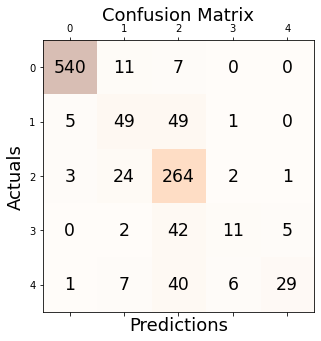

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
y_true = pd.read_csv('/content/train.csv',index_col="id_code") 

# Demo

0 – No DR, 1 – Mild, 2 – Moderate, 3 – Severe, 4 – Proliferative DR( DR tăng sinh))

In [ ]:
Demo =demo('0dce95217626')

1/1 [==============================] - 1s 806ms/step
predicted results:  1-Mild


In [ ]:
y_true.loc['0dce95217626']

diagnosis    1
Name: 0dce95217626, dtype: int64